<a href="https://colab.research.google.com/github/pulakeshpradhan/Concepts-of-Programming/blob/main/Earth_Engine_Data_to_Python_Converters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2023 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Earth Engine Data Converters
Author: jdbcode

Data converters are client-side conversion capabilities built into [`getPixels`](https://developers.google.com/earth-engine/apidocs/ee-data-getpixels), [`computePixels`](https://developers.google.com/earth-engine/apidocs/ee-data-computepixels), [`listFeatures`](https://developers.google.com/earth-engine/apidocs/ee-data-listfeatures), and [`computeFeatures`](https://developers.google.com/earth-engine/apidocs/ee-data-computefeatures). By specifying a compatible `fileFormat`, these methods can return data in Python-native formats like structured NumPy arrays for rasters and Pandas DataFrames or GeoPandas GeoDataFrames for vectors. In the case of vectors, the `listFeatures` and `computeFeatures` methods will make several network requests to fetch all the pages of the table before returning the Python object.

All of these methods transfer data from Earth Engine servers to a client machine using the [interactive processing environment](https://developers.google.com/earth-engine/guides/processing_environments#interactive_environment), which is optimized for answering small requests quickly. As such, it enforces limits on request size and compute time. You'll need to keep this in mind as you're coding your analysis and decide whether exporting data using the [batch processing environment](https://developers.google.com/earth-engine/guides/processing_environments#batch_environment) would be better. For example, see `ee.data.computePixel` limits in the [reference docs](https://developers.google.com/earth-engine/reference/rest/v1/projects.image/computePixels).

Some common use cases for data converters are fetching many small image tiles in parallel (e.g., training ML models or automated serial workflows) and for visualization and data exploration with your favorite Python libraries. This notebook focuses on data exploration and visualization; if you're interested in learning about fetching data in parallel, see the Medium blog post "[Pixels to the people!](https://medium.com/google-earth/pixels-to-the-people-2d3c14a46da6)".

# Setup

Import libraries and authenticate to Earth Engine and initialize the API.

In [ ]:
import altair as alt
import ee
import eerepr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
ee.Authenticate()
ee.Initialize(project='geospatialresearchacademy')

# Data

In this notebook we'll be looking at watersheds in Washington state (USA) and long-term climate averages.

Define asset paths for [basins](https://developers.google.com/earth-engine/datasets/catalog/WWF_HydroSHEDS_v1_Basins_hybas_6), [state boundaries](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level1), and [climate averages](https://developers.google.com/earth-engine/datasets/catalog/WORLDCLIM_V1_MONTHLY).

In [ ]:
BASINS_ID = 'WWF/HydroSHEDS/v1/Basins/hybas_6'
BOUNDARIES_ID = 'FAO/GAUL/2015/level1'
CLIMATE_ID = 'WORLDCLIM/V1/MONTHLY'

Import the basins asset and subset watersheds that intersect Washington state. The result is a `ee.FeatureCollection`.

In [ ]:
basins = ee.FeatureCollection(BASINS_ID)
wa = ee.FeatureCollection(BOUNDARIES_ID).filter(
    'ADM0_NAME == "United States of America" && '
    'ADM1_NAME == "Washington"'
)

wa_basins = basins.filterBounds(wa)

Import the WorldClim climate image collection (each image is the average historical climate for a month), subset the precipitation band and stack the individual images into a single image (each band represents a historical monthly mean). Inspect the resulting `ee.Image` band names to see that bands are named like `prec_month_01` and `prec_month_02`, indicating mean precipitation for January and February, respectively.

In [ ]:
precip = ee.ImageCollection(CLIMATE_ID).select('prec')

months = precip.aggregate_array('month').getInfo()

band_names = [f'prec_month_{str(m).zfill(2)}' for m in months]

monthly_precip = ee.Image(precip.toBands().rename(band_names))

monthly_precip.bandNames()

Calculate historical mean monthly precipitation for each Washington watershed. These zonal statistics are added as attributes to the `wa_basins` feature collection.

In [ ]:
wa_basins = monthly_precip.reduceRegions(
    collection=wa_basins,
    reducer=ee.Reducer.mean(),
    scale=1e3
)

# Converters

In the following sections we'll convert the Earth Engine objects defined above into Python-native formats for visualization and exploring. A distinction is made between **computed** and **stored** Earth Engine data because data converter functions are specific to each type.

## Computed Earth Engine data

Computed Earth Engine data are those that are generated on the fly through instantiation of non-asset data, computation, or manipulation; they are not stored on disk for later retrieval. To request conversion of computed data, you can use the `ee.data.computeFeatures` and `ee.data.computePixels` functions for `ee.FeatureCollection` and `ee.Image` objects, respectively.

### `FeatureCollection` to Pandas `DataFrame`

An `ee.FeatureCollection` is Earth Engine's table data type. Each `ee.Feature` in the collection can be thought of as a row and each of its properties as a column - one column stores the geometry. The EE API has a rich set of methods for working with feature collections, but feature collections are difficult to view as a table and you may prefer to use [Pandas](https://pandas.pydata.org/) for analysis. We can transfer the data client-side as a Pandas `DataFrame`.


We can print the head of the Washington watersheds feature collection to preview the table, but the JSON structure makes it hard to interpret and conceptualize as a table (even with the help of `eerep` for rich object representation).

In [ ]:
wa_basins.limit(5)

Use the `ee.data.computeFeatures` with the `fileFormat` parameter set to `'PANDAS_DATAFRAME'` to get the data as a Pandas `DataFrame`.



In [ ]:
wa_basins_df = ee.data.computeFeatures({
    'expression': wa_basins,
    'fileFormat': 'PANDAS_DATAFRAME'
})

Print the object's type and see that it is `pandas.core.frame.DataFrame
`. Printing the head of the object shows the nicely formatted table.

In [ ]:
display(type(wa_basins_df))
wa_basins_df.head()

pandas.core.frame.DataFrame

,geo,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,...,prec_month_03,prec_month_04,prec_month_05,prec_month_06,prec_month_07,prec_month_08,prec_month_09,prec_month_10,prec_month_11,prec_month_12
0,"{'type': 'Polygon', 'coordinates': [[[-122.779...",0,110.2,110.2,0,7060394690,7060014930,7060014930,7060014930,1,...,146.878556,94.144313,63.522701,46.212289,17.660385,29.402129,53.578550,105.356210,206.618729,234.763442
1,"{'type': 'Polygon', 'coordinates': [[[-120.916...",0,285.3,285.3,0,7060395190,7060014930,7060394690,7060014930,1,...,27.615579,17.833143,16.877648,13.897495,5.764290,9.287812,12.273582,22.117477,45.264017,50.782735
2,"{'type': 'Polygon', 'coordinates': [[[-120.704...",0,311.1,311.1,0,7060392060,7060014930,7060395190,7060014930,1,...,28.012583,20.677475,18.804275,15.705302,6.606818,10.505247,13.456117,21.139254,47.818868,52.247916
3,"{'type': 'Polygon', 'coordinates': [[[-120.350...",0,369.9,369.9,0,7060390130,7060014930,7060392060,7060014930,1,...,21.068784,17.882572,19.457691,15.483754,5.833698,9.179610,11.897550,18.171781,32.700848,35.842826
4,"{'type': 'Polygon', 'coordinates': [[[-119.358...",0,430.7,430.7,0,7060386330,7060014930,7060390130,7060014930,1,...,27.308765,21.875911,24.330597,17.802391,6.996754,10.967107,13.673581,21.972353,37.138641,38.597492


Now we can use Pandas syntax to convert the wide table into a long table so that month is a factor and precipitation is a variable.

In [ ]:
wa_basins_df = wa_basins_df.melt(
    id_vars=["HYBAS_ID"],
    value_vars=band_names,
    var_name="Month",
    value_name="Precipitation",
)
wa_basins_df

,HYBAS_ID,Month,Precipitation
0,7060394690,prec_month_01,234.094567
1,7060395190,prec_month_01,50.684768
2,7060392060,prec_month_01,48.154425
3,7060390130,prec_month_01,32.510998
4,7060386330,prec_month_01,37.587224
...,...,...,...
523,7060014940,prec_month_12,365.592079
524,7060015100,prec_month_12,339.398352
525,7060015910,prec_month_12,217.663979
526,7060016010,prec_month_12,226.606896


We can use Pandas' [`groupby`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method and built-in [matplotlib charting wrappers](https://pandas.pydata.org/docs/user_guide/visualization.html#basic-plotting-plot) for a quick look at mean total annual precipition for each watershed.

<Axes: xlabel='HYBAS_ID'>

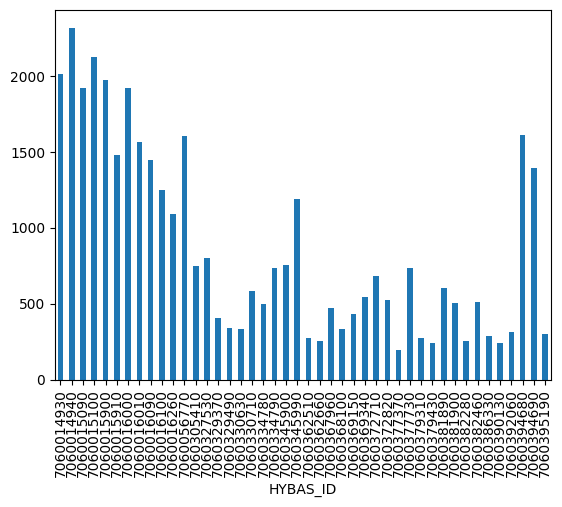

In [ ]:
wa_basins_df.groupby(['HYBAS_ID'])['Precipitation'].sum().plot.bar()

There are lots of charting libraries for visualizing `DataFrame` objects. Here, we plot the data with [Altair](https://altair-viz.github.io/gallery/index.html#) using a stacked column chart to show the total mean annual precipitation (by monthly contribution) for each watershed intersecting Washington state.  We can see quite a range in total precipitation and that summer months are generally drier than other months.

In [ ]:
alt.Chart(wa_basins_df).mark_bar().encode(
    x=alt.X('HYBAS_ID:O'),
    y=alt.Y('Precipitation:Q', title='Precipitation (mm)'),
    color=alt.Color('Month', scale=alt.Scale(scheme='rainbow')),
    tooltip=alt.Tooltip(['HYBAS_ID', 'Precipitation', 'Month'])
).interactive()

alt.Chart(...)

### `FeatureCollection` to GeoPandas `GeoDataFrame`

Use the `ee.data.computeFeatures` with the `fileFormat` parameter set to `'GEOPANDAS_GEODATAFRAME'` to get the Washington basins climate data as a [GeoPandas](https://geopandas.org/en/v0.14.0/index.html) `GeoDataFrame`. It allows you to use the table manipulation and querying functions of Pandas, in addition to geospatial operations and visualizations.

In [ ]:
wa_basins_gdf = ee.data.computeFeatures({
    'expression': wa_basins,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
wa_basins_gdf.crs = 'EPSG:4326'

display(type(wa_basins_gdf))
wa_basins_gdf.head()

geopandas.geodataframe.GeoDataFrame

,geometry,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,...,prec_month_03,prec_month_04,prec_month_05,prec_month_06,prec_month_07,prec_month_08,prec_month_09,prec_month_10,prec_month_11,prec_month_12
0,"POLYGON ((-122.77984 45.62517, -122.77850 45.6...",0,110.2,110.2,0,7060394690,7060014930,7060014930,7060014930,1,...,146.878556,94.144313,63.522701,46.212289,17.660385,29.402129,53.578550,105.356210,206.618729,234.763442
1,"POLYGON ((-120.91667 45.63750, -120.90833 45.6...",0,285.3,285.3,0,7060395190,7060014930,7060394690,7060014930,1,...,27.615579,17.833143,16.877648,13.897495,5.764290,9.287812,12.273582,22.117477,45.264017,50.782735
2,"POLYGON ((-120.70416 45.83750, -120.70381 45.8...",0,311.1,311.1,0,7060392060,7060014930,7060395190,7060014930,1,...,28.012583,20.677475,18.804275,15.705302,6.606818,10.505247,13.456117,21.139254,47.818868,52.247916
3,"POLYGON ((-120.35000 46.03750, -120.34891 46.0...",0,369.9,369.9,0,7060390130,7060014930,7060392060,7060014930,1,...,21.068784,17.882572,19.457691,15.483754,5.833698,9.179610,11.897550,18.171781,32.700848,35.842826
4,"POLYGON ((-119.35833 45.95833, -119.35774 45.9...",0,430.7,430.7,0,7060386330,7060014930,7060390130,7060014930,1,...,27.308765,21.875911,24.330597,17.802391,6.996754,10.967107,13.673581,21.972353,37.138641,38.597492


Fetch the Washington state boundary as `GeoDataFrame` too.

In [ ]:
wa_gdf = ee.data.computeFeatures({
    'expression': wa,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

wa_gdf.crs = 'EPSG:4326'

Clip the watershed geometries by the Washington state boundary using the `GeoDataFrame.clip` method and convert the original mercator projection to a Washington-specific projection for better visualization.

In [ ]:
wa_basins_gdf = wa_basins_gdf.clip(wa_gdf).to_crs(2856)

Sum the 12 months of mean precipitation for each watershed and append the values in a new column called `prec_total`.

In [ ]:
wa_basins_gdf['prec_total'] = wa_basins_gdf[band_names].sum(axis=1)
wa_basins_gdf.head()

,geometry,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,...,prec_month_04,prec_month_05,prec_month_06,prec_month_07,prec_month_08,prec_month_09,prec_month_10,prec_month_11,prec_month_12,prec_total
11,"POLYGON ((323681.256 38652.563, 323675.358 384...",0,110.3,110.3,0,7060394680,7060014930,7060014930,7060014930,2,...,112.513157,80.506743,54.895933,20.152861,31.470921,59.977676,120.364084,246.904406,268.791477,1612.022388
1,"POLYGON ((467558.207 34606.838, 467927.079 352...",0,285.3,285.3,0,7060395190,7060014930,7060394690,7060014930,1,...,17.833143,16.877648,13.897495,5.764290,9.287812,12.273582,22.117477,45.264017,50.782735,302.936212
0,"POLYGON ((323681.256 38652.563, 324195.862 386...",0,110.2,110.2,0,7060394690,7060014930,7060014930,7060014930,1,...,94.144313,63.522701,46.212289,17.660385,29.402129,53.578550,105.356210,206.618729,234.763442,1397.917320
36,"MULTIPOLYGON (((272907.881 108054.961, 273076....",0,0.0,0.0,0,7060014930,7060014930,0,7060014930,1,...,139.758895,93.194343,72.178947,30.306009,46.373500,83.750910,161.842562,301.742886,322.848658,2014.252252
39,"MULTIPOLYGON (((229004.483 186948.963, 229005....",1,0.0,0.0,0,7060014940,7060014940,0,7060014940,0,...,161.688406,101.882578,74.140903,39.682854,50.261698,96.686944,201.159668,342.369779,365.592079,2321.440637


Use [matplotlib](https://matplotlib.org/) to plot a choropleth map of mean annual precipitation by watershed and highlight the watershed with the minimum precipitation using a red border.

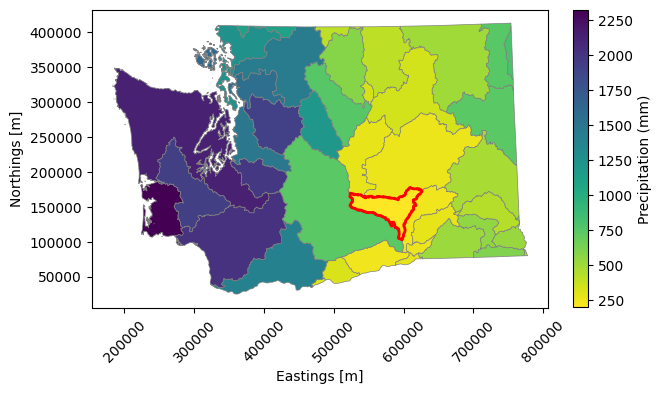

In [ ]:
# Define the choropleth map.
ax = wa_basins_gdf.plot(
    column='prec_total',
    cmap='viridis_r',
    vmin=wa_basins_gdf['prec_total'].min(),
    vmax=wa_basins_gdf['prec_total'].max(),
    legend=False,
    edgecolor='grey', linewidth=0.5
)

# Highlight the basin with the minimum annual precipitation: subset the geometry
# with the minimum precipitation total and then add it to the basin
# precipitation plot.
min_prec_gdf = wa_basins_gdf.loc[[wa_basins_gdf['prec_total'].idxmin()]]
min_prec_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

# Add axis labels, a colorbar, and rotate x axis ticks.
ax.set_xlabel('Eastings [m]')
ax.set_ylabel('Northings [m]')
colorbar = plt.colorbar(ax.get_children()[0], fraction=0.03)
colorbar.set_label('Precipitation (mm)')
plt.xticks(rotation=45)

plt.show()

### `Image` to NumPy structured array

Here we use `ee.data.computePixels` to request the `monthly_precip` computed Earth Engine image (each band is mean precipitation for a given month) as a [NumPy structured array](https://numpy.org/doc/stable/user/basics.rec.html). It is a global dataset, so we'll request only the Washington state basins bounding region at a resolution of 1500 meters. We can use the [`ee.Image.clipToBoundsAndScale`](https://developers.google.com/earth-engine/apidocs/ee-image-cliptoboundsandscale#colab-python) function to do this, which is a convenient alternative to supplying the `grid` argument.

In [ ]:
monthly_precip_washington = monthly_precip.clipToBoundsAndScale(
    geometry=wa_basins, scale=1500
)

monthly_precip_npy = ee.data.computePixels({
    'expression': monthly_precip_washington,
    'fileFormat': 'NUMPY_NDARRAY'
})

monthly_precip_npy

array([[( 1.51e+02,  1.07e+02,  9.5e+01,  6.7e+01,  6.1e+01,  5.7e+01,  5.6e+01,  5.1e+01,  6.6e+01,  1.29e+02,  1.51e+02,  1.52e+02),
        ( 1.49e+02,  1.05e+02,  9.2e+01,  6.5e+01,  6.0e+01,  5.5e+01,  5.4e+01,  4.9e+01,  6.6e+01,  1.33e+02,  1.52e+02,  1.50e+02),
        ( 1.49e+02,  1.06e+02,  9.5e+01,  6.7e+01,  6.1e+01,  5.7e+01,  5.6e+01,  5.1e+01,  6.6e+01,  1.26e+02,  1.49e+02,  1.51e+02),
        ...,
        ( 2.60e+01,  2.40e+01,  2.5e+01,  4.0e+01,  5.8e+01,  8.5e+01,  5.9e+01,  5.5e+01,  4.6e+01,  2.30e+01,  2.00e+01,  2.50e+01),
        ( 2.50e+01,  2.40e+01,  2.4e+01,  3.9e+01,  5.7e+01,  8.5e+01,  5.9e+01,  5.5e+01,  4.6e+01,  2.20e+01,  1.90e+01,  2.40e+01),
        ( 2.50e+01,  2.40e+01,  2.4e+01,  3.9e+01,  5.7e+01,  8.5e+01,  5.9e+01,  5.5e+01,  4.6e+01,  2.20e+01,  1.90e+01,  2.40e+01)],
       [( 1.51e+02,  1.06e+02,  9.4e+01,  6.6e+01,  6.0e+01,  5.6e+01,  5.4e+01,  5.0e+01,  6.6e+01,  1.36e+02,  1.55e+02,  1.53e+02),
        ( 1.50e+02,  1.05e+02,  9.2e+01, 

NumPy structured arrays work well for multiband image data. You can think of them as a table of arrays where each band is a column accessible from a field (band) name. It also permits each band to have a different data type.

For example, get the list of field (band) names and then subset an array by name and print its shape and display a preview of it.

field names: ('prec_month_01', 'prec_month_02', 'prec_month_03', 'prec_month_04', 'prec_month_05', 'prec_month_06', 'prec_month_07', 'prec_month_08', 'prec_month_09', 'prec_month_10', 'prec_month_11', 'prec_month_12')
Selected array (band) shape: (556, 834)


array([[ 1.29e+02,  1.33e+02,  1.26e+02, ...,  2.30e+01,  2.20e+01,
         2.20e+01],
       [ 1.36e+02,  1.39e+02,  1.54e+02, ...,  2.30e+01,  2.30e+01,
         2.20e+01],
       [ 1.48e+02,  1.40e+02,  1.62e+02, ...,  2.30e+01,  2.30e+01,
         2.20e+01],
       ...,
       [-3.40e+38, -3.40e+38, -3.40e+38, ...,  2.00e+01,  1.90e+01,
         1.90e+01],
       [-3.40e+38, -3.40e+38, -3.40e+38, ...,  1.90e+01,  1.90e+01,
         1.90e+01],
       [-3.40e+38, -3.40e+38, -3.40e+38, ...,  2.00e+01,  1.80e+01,
         1.80e+01]], dtype=float32)

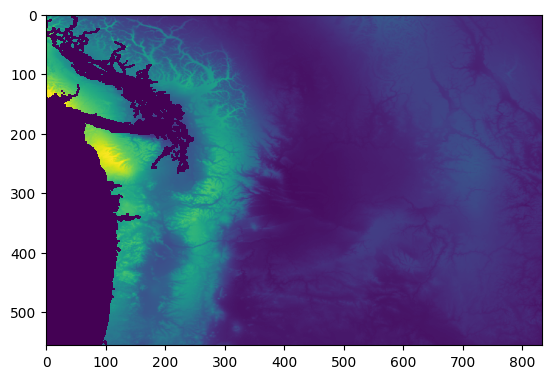

In [ ]:
names = monthly_precip_npy.dtype.names
print('field names:', names)

prec_month_10_arr = monthly_precip_npy['prec_month_10']
print('Selected array (band) shape:', prec_month_10_arr.shape)
display(prec_month_10_arr)
plt.imshow(prec_month_10_arr, vmin=0, vmax=320)

Since we have all months of mean precipitation, we can use the matplotlib [`ImageGrid`](https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html) function to show a time series grid for simple visual interpolation of intra-annual precipitation patterns.

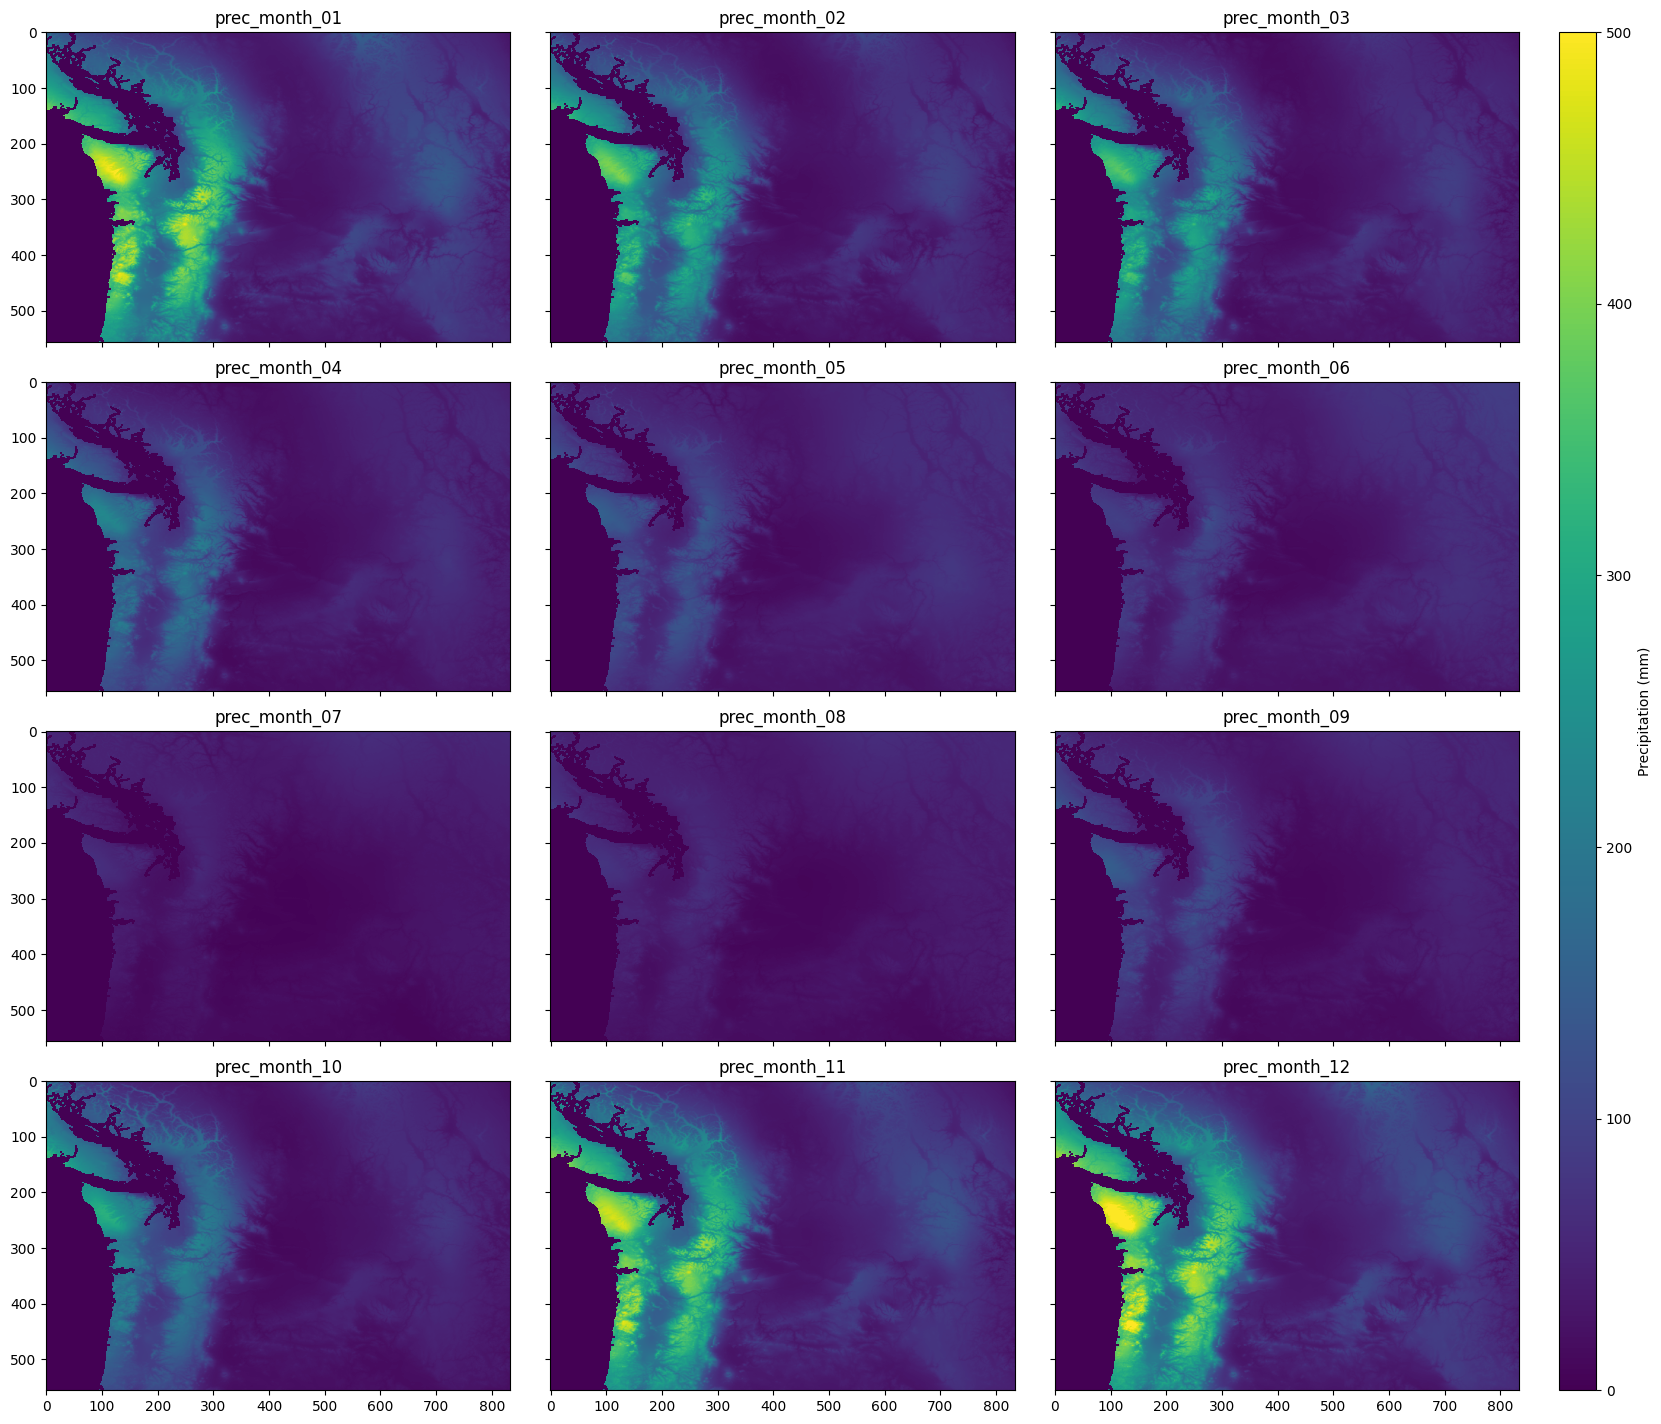

In [ ]:
# Set up the figure and grid.
fig = plt.figure(figsize=(20.0, 20.0))
grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(4, 3),
    axes_pad=0.4,
    cbar_mode="single",
    cbar_location="right",
    cbar_pad=0.4,
    cbar_size="2%",
)

# Display each band to a grid cell.
for ax, name in zip(grid, names):
    ax.imshow(monthly_precip_npy[name], vmin=0, vmax=500)
    ax.set_title(name)

# Add colorbar.
colorbar = plt.colorbar(ax.get_children()[0], cax=grid[0].cax)
colorbar.set_label("Precipitation (mm)")

plt.show()

## Stored Earth Engine data

Stored Earth Engine data are those that exist as assets in the [public data catalog](https://developers.google.com/earth-engine/datasets) or personal and shared cloud projects. To request conversion of stored data, you can use the `ee.data.listFeatures` and `ee.data.getPixels` functions for `ee.FeatureCollection` and `ee.Image` objects, respectively.

### `FeatureCollection` to Pandas `DataFrame`

We use the `ee.data.listFeatures` function to get a Pandas `DataFrame` from a stored `FeatureCollection` asset. The process is similar to converting a computed `FeatureCollection` (see above), but since we can't manipulate the `FeatureCollection` there are extra parameters to optionally specify the region and filter by property values. In this case, we subset the global watershed dataset to those that intersect Washington state using the `region` parameter and apply a filter to only include watersheds that are greater than or equal to river order 3, using the `filter` parameter.





In [ ]:
high_order_wa_basins_df = ee.data.listFeatures({
    'assetId': 'WWF/HydroSHEDS/v1/Basins/hybas_6',
    'region': wa.geometry().getInfo(),
    'filter': 'ORDER >= 3',
    'fileFormat': 'PANDAS_DATAFRAME'
})

high_order_wa_basins_df

,geo,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,PFAF_ID,SORT,SUB_AREA,UP_AREA
0,"{'type': 'Polygon', 'coordinates': [[[-121.520...",0,508.7,508.7,0,7060377730,7060014930,7060379430,7060014930,3,782612,277,15930.4,15930.4
1,"{'type': 'Polygon', 'coordinates': [[[-119.966...",0,633.1,633.1,0,7060362660,7060014930,7060377370,7060014930,3,782614,282,11946.4,11946.5
2,"{'type': 'Polygon', 'coordinates': [[[-121.179...",0,727.6,727.6,0,7060345990,7060014930,7060362510,7060014930,3,782616,286,3473.4,3473.4
3,"{'type': 'Polygon', 'coordinates': [[[-120.788...",0,819.8,819.8,0,7060330710,7060014930,7060345900,7060014930,3,782618,292,4680.6,4680.8
4,"{'type': 'Polygon', 'coordinates': [[[-121.099...",0,835.0,835.0,0,7060329370,7060014930,7060330630,7060014930,3,782620,294,21385.8,21385.8
5,"{'type': 'Polygon', 'coordinates': [[[-118.345...",0,1010.9,1010.9,0,7060334790,7060014930,7060329490,7060014930,3,782640,299,17353.6,17353.6
6,"{'type': 'Polygon', 'coordinates': [[[-117.662...",0,1181.3,1181.3,0,7060305410,7060014930,7060334780,7060014930,3,782661,308,4292.1,67055.5
7,"{'type': 'Polygon', 'coordinates': [[[-117.188...",0,1335.1,1335.1,0,7060327530,7060014930,7060305410,7060014930,4,782662,323,2549.2,2549.2


### `FeatureCollection` to GeoPandas `GeoDataFrame`

If we change the `fileFormat` argument to `'GEOPANDAS_GEODATAFRAME'`, we'll get a GeoPandas `GeoDataFrame`.

In [ ]:
high_order_wa_basins_gdf = ee.data.listFeatures({
    'assetId': 'WWF/HydroSHEDS/v1/Basins/hybas_6',
    'region': wa.geometry().getInfo(),
    'filter': 'ORDER >= 3',
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

display(type(wa_basins_gdf))
high_order_wa_basins_gdf

geopandas.geodataframe.GeoDataFrame

,geometry,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,PFAF_ID,SORT,SUB_AREA,UP_AREA
0,"POLYGON ((-121.52084 46.87500, -121.51998 46.8...",0,508.7,508.7,0,7060377730,7060014930,7060379430,7060014930,3,782612,277,15930.4,15930.4
1,"POLYGON ((-119.96666 47.18750, -119.96582 47.1...",0,633.1,633.1,0,7060362660,7060014930,7060377370,7060014930,3,782614,282,11946.4,11946.5
2,"POLYGON ((-121.17973 47.90491, -121.17860 47.8...",0,727.6,727.6,0,7060345990,7060014930,7060362510,7060014930,3,782616,286,3473.4,3473.4
3,"POLYGON ((-120.78807 48.62008, -120.78390 48.6...",0,819.8,819.8,0,7060330710,7060014930,7060345900,7060014930,3,782618,292,4680.6,4680.8
4,"POLYGON ((-121.09999 49.40625, -121.09619 49.4...",0,835.0,835.0,0,7060329370,7060014930,7060330630,7060014930,3,782620,294,21385.8,21385.8
5,"POLYGON ((-118.34584 47.89167, -118.34584 47.8...",0,1010.9,1010.9,0,7060334790,7060014930,7060329490,7060014930,3,782640,299,17353.6,17353.6
6,"POLYGON ((-117.66250 48.91250, -117.66004 48.9...",0,1181.3,1181.3,0,7060305410,7060014930,7060334780,7060014930,3,782661,308,4292.1,67055.5
7,"POLYGON ((-117.18807 48.74045, -117.18693 48.7...",0,1335.1,1335.1,0,7060327530,7060014930,7060305410,7060014930,4,782662,323,2549.2,2549.2


Display the high order watersheds in Washington with its border so we can see their location in the state.

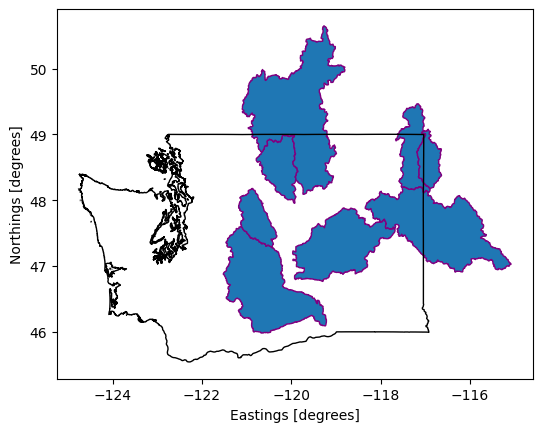

In [ ]:
# Create an initial plot with the high river order watersheds.
ax = high_order_wa_basins_gdf.plot(edgecolor='purple', linewidth=1)

# Overlay the Washington state border for context.
wa_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Set axis labels.
ax.set_xlabel('Eastings [degrees]')
ax.set_ylabel('Northings [degrees]')

plt.show()

### `Image` to NumPy structured array

Here we use `ee.data.getPixels` to request the global historical average temperature for January (according to the WorldClim data) as a NumPy structured array. Unlike `ee.data.computePixels` (above), we can't use the very convenient `ee.Image.clipToBoundsAndScale` function to define the request region and scale because we need to access the asset directly without manipulation. Instead, we have to use the more verbose and less intuitive `grid` parameter.

The `grid` argument in our request starts by defining a global 1-degree grid and then applies a scale factor of 5 to get higher resolution.

In [ ]:
SCALE_FACTOR = 5

jan_mean_temp_npy = ee.data.getPixels({
    'assetId': 'WORLDCLIM/V1/MONTHLY/01',
    'fileFormat': 'NUMPY_NDARRAY',
    'grid': {
        'dimensions': {
            'width': 360 * SCALE_FACTOR,
            'height': 180 * SCALE_FACTOR
        },
        'affineTransform': {
            'scaleX': 1 / SCALE_FACTOR,
            'shearX': 0,
            'translateX': -180,
            'shearY': 0,
            'scaleY': -1 / SCALE_FACTOR,
            'translateY': 90
        },
        'crsCode': 'EPSG:4326',
    },
    'bandIds': ['tavg']
})

jan_mean_temp_npy

array([[(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)],
       [(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)],
       [(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)],
       ...,
       [(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)],
       [(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)],
       [(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)]], dtype=[('tavg', '<f4')])

Extract the `'tavg'` band from the structured array, set the background values as `nan`, and scale the temperature values to the appropriate range.

In [ ]:
jan_mean_temp_npy = jan_mean_temp_npy['tavg']

jan_mean_temp_npy = np.where(jan_mean_temp_npy < -9999, np.nan, jan_mean_temp_npy)
jan_mean_temp_npy = jan_mean_temp_npy * 0.1
jan_mean_temp_npy

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

Plot the 2D array as an image using matplotlib.

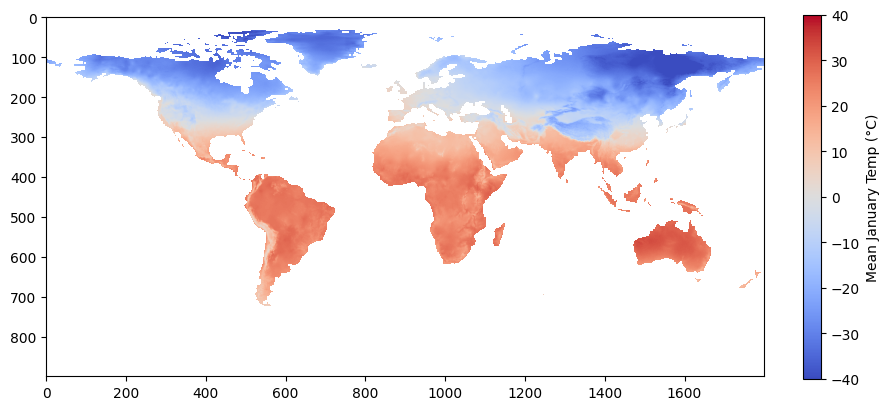

In [ ]:
fig = plt.figure(figsize=(10., 10.))
ax = plt.imshow(jan_mean_temp_npy, cmap='coolwarm', vmin=-40, vmax=40)

colorbar = plt.colorbar(ax, fraction=0.0235)
colorbar.set_label('Mean January Temp (°C)')

plt.show()